In [1]:
import torch
from torch import nn
import torchvision
from torch.utils.data import TensorDataset
import numpy as np
from torch.utils.data.dataloader import DataLoader

In [2]:
torch.cuda.empty_cache()

In [3]:
torch.cuda.is_available()

True

# Patch Embedding

In [4]:
class TubeletEmbedding(nn.Module):
    """ Split image into patches and convert into embeddings
    
    Parameters
    ____________
    img_size: int
        Size of the image
    patch_size: int
        Size of each patch
    in_channel: int
        number of input chanels
    embedding: int
        the embedding dimension
        
    Attributes
    ____________
    self.n_patches: int
        Number of patches to split the image into
    self.proj: Conv3D()
        Convert image into patches and give their embeddings
        
    """
    def __init__(self, img_size, temporal_size, patch_size, in_chans=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = ((self.img_size // patch_size)**2) * (temporal_size // patch_size)
        self.proj = nn.Conv3d(
            in_chans, 
            embed_dim, 
            kernel_size=patch_size, 
            stride=patch_size
        )
    
    def forward(self, x):
        """Run Forward Pass
        
        Parameters
        ______________
        x: torch.Tensor
            Shape (n_samples, in_channel, img_size, img_size)
        
        Returns
        ______________
        torch.Tensor
            Shape (n_samples, n_patches, embedding)
        
        """
        x = self.proj(x) # Shape (no_of_samples, embedding_dim, temporal_dimension, n_patches ** 1/2, n_patches ** 1/2)
        x = x.flatten(2) # Shape (no_of_samples, embedding_dim, n_patches)
        x = x.transpose(1, 2) # Shape (no_of_samples, n_patches, embedding_dim)
        return x

In [5]:
inps = torch.rand((1, 3, 8, 224, 224))                                      
inps.shape

torch.Size([1, 3, 8, 224, 224])

In [6]:
tgts = torch.rand((1, 1))                                      
tgts.shape

torch.Size([1, 1])

In [7]:
dataset = TensorDataset(inps, tgts)

In [8]:
dataloader = DataLoader(dataset, batch_size=1) 

In [9]:
dataset_iter = iter(dataloader)

In [10]:
patch_embedding = TubeletEmbedding(224, 8, 8).cuda()

In [11]:
for inp, gt in dataset_iter:
    inp = inp.cuda()
    print("input shape: ", inp.shape)
    print(patch_embedding(inp).shape)

input shape:  torch.Size([1, 3, 8, 224, 224])
torch.Size([1, 784, 768])


# Attention

In [12]:
module = torch.nn.Dropout(0.50)
print("Training mode: ", module.training)
x = np.ones((2, 2))
convert_to_tensor = torchvision.transforms.ToTensor()
x = convert_to_tensor(x)
print(module(x))

module.eval()
print("Training mode: ", module.training)
print(module(x))

Training mode:  True
tensor([[[2., 0.],
         [0., 2.]]], dtype=torch.float64)
Training mode:  False
tensor([[[1., 1.],
         [1., 1.]]], dtype=torch.float64)


In [13]:
class Attention(nn.Module):
    """ Split image into patches and convert into embeddings
    
    Parameters
    _____________
    dim: int
        Input dimensions (positional aware embeddings) and output dimensions stay the same
        
    n_heads: int
        Number of self attention modules to distribute the cognitive load
        
    qkv_bias: bool
        Whether to add bias in query, keys and value projections
        
    attn_p: float
        dropout applied to q, k and v
        
    proj_p: float
        dropout applied to output
        
    Attributes
    _____________
    proj: nn.Linear
        input channels = dim, output channels = dim to map concatenated attention heads output to a new space
        
    """
    def __init__(self, dim, n_heads, qkv_bias=True, attn_p=0., proj_p=0.):
        super().__init__()
        self.n_heads = n_heads
        self.dim = dim
        self.head_dim = self.dim // n_heads
        self.scale = self.head_dim ** -0.5
        
        self.qkv = nn.Linear(dim, dim*3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_p)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_p)
        
        
    def forward(self, x):
        """Run Forward Pass
        
        Parameters
        ______________
        x: torch.Tensor
            Shape (n_samples, n_patches + 1, embedding)
        
        Returns
        ______________
        torch.Tensor
            Shape (n_samples, n_patches + 1, embedding)
        
        """
        n_samples, n_tokens, dim = x.shape
        if dim != self.dim:
            raise ValueError
        qkv = self.qkv(x) # (n_samples, n_patches + 1, embedding_dim * 3)
        qkv = qkv.reshape(n_samples, n_tokens, 3, self.n_heads, self.head_dim) # (n_samples, n_patches + 1, 3, n_heads, head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4) # (3, n_samples, self.n_heads, n_patches + 1, head_dim)
        q, k, v = qkv[0], qkv[1], qkv[2]
        k_t = k.transpose(-2, -1) # (n_samples, self.n_heads, head_dim, n_patches + 1)
        
        dp = (q @ k_t) * self.scale # (n_samples, self.n_heads, n_patches + 1, n_patches + 1)
        attn = dp.softmax(dim=-1)
        attn = self.attn_drop(attn)
        weighted_avg = attn @ v # (n_samples, self.n_heads, n_patches + 1, head_dim)
        weighted_avg = weighted_avg.transpose(1, 2) # (n_samples, n_patches + 1, self.n_heads, head_dim)
        weighted_avg = weighted_avg.flatten(2) # (n_samples, n_patches + 1, embedding_dim)
        
        x = self.proj(weighted_avg) # (n_samples, n_patches + 1, embedding_dim)
        x = self.proj_drop(x) # (n_samples, n_patches + 1, embedding_dim)
        
        return x

In [14]:
dataset_iter = iter(dataloader)

In [15]:
attn = Attention(768, 12, True, 0, 0) # 12 attention heads, so the dimension of each head is 768/12=64
attn = attn.cuda()
for inp, gt in dataset_iter:
    inp = inp.cuda()
    patch_emb = patch_embedding(inp)
    # Skipping the positonal aware embeddings for now
    print(attn(patch_emb).shape)
    break

torch.Size([1, 784, 768])


In [16]:
class MLP(nn.Module):
    '''Parameters
    _____________________
    in_features: int
        Number of input features
        
    hidden_features: int
        Number of hidden features
        
    out_features: int
        Number of output features
        
    p: float
        Dropout probability
    
    Attributes
    ______________________
    fc: nn.Linear
        The first linear layer
        
    fc2: nn.Linear
        The second linear layer
        
    act: nn.GELU
        GELU activation function
        
    dropout: nn.Dropout
        Dropout layer'''
    def __init__(self, in_features, hidden_features, out_features, p=0.):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(p)
    
    def forward(self, x):
        '''
        Parameters
        __________________
        x: torch.Tensor -> (n_samples, n_patches + 1, embedding_dim)
        
        Returns
        __________________
        x: torch.Tensor -> (n_samples, n_patches + 1, embedding_dim)'''
        x = self.fc1(
                x
        ) # (n_samples, n_patches + 1, hidden_features)
        x = self.act(x)  # (n_samples, n_patches + 1, hidden_features)
        x = self.drop(x)  # (n_samples, n_patches + 1, hidden_features)
        x = self.fc2(x)  # (n_samples, n_patches + 1, out_features)
        x = self.drop(x)  # (n_samples, n_patches + 1, out_features)

        return x

In [17]:
class Block(nn.Module):
        """Transformer block.
        Parameters
        ----------
        dim : int
            Embeddinig dimension.

        n_heads : int
            Number of attention heads.

        mlp_ratio : float
            Determines the hidden dimension size of the `MLP` module with respect
            to `dim`.

        qkv_bias : bool
            If True then we include bias to the query, key and value projections.

        p, attn_p : float
            Dropout probability.

        Attributes
        ----------
        norm1, norm2 : LayerNorm
            Layer normalization.

        attn : Attention
            Attention module.

        mlp : MLP
            MLP module.
        """
        def __init__(self, dim, n_heads, mlp_ratio=4.0, qkv_bias=True, p=0., attn_p=0.):
            super().__init__()
            self.norm1 = nn.LayerNorm(dim, eps=1e-6)
            self.attn = Attention(
                dim, 
                n_heads, 
                qkv_bias=qkv_bias,
                attn_p=attn_p,
                proj_p=p
            )
            self.norm2 = nn.LayerNorm(dim, eps=1e-6)
            self.mlp = MLP(
                dim, 
                int(dim * mlp_ratio), 
                dim
            )
            
        def forward(self, x):
            '''
            Parmeters
            _______________
            x: torch.Tensor -> Shape (no_of_samples, n_patches + 1, embedding_dim)
            
            Returns
            _______________
            x: torch.Tensor -> Shape (no_of_samples, n_patches + 1, embedding_dim)
            '''
            x = x + self.attn(self.norm1(x))
            x = x + self.mlp(self.norm2(x))

            return x

In [18]:
class VideoVisionTransformer(nn.Module):
    """Simplified implementation of the Vision transformer.

    Parameters
    ----------
    img_size : int
        Both height and the width of the image (it is a square).

    patch_size : int
        Both height and the width of the patch (it is a square).

    in_chans : int
        Number of input channels.

    n_classes : int
        Number of classes.

    embed_dim : int
        Dimensionality of the token/patch embeddings.

    depth : int
        Number of blocks.

    n_heads : int
        Number of attention heads.

    mlp_ratio : float
        Determines the hidden dimension of the `MLP` module.

    qkv_bias : bool
        If True then we include bias to the query, key and value projections.

    p, attn_p : float
        Dropout probability.

    Attributes
    ----------
    patch_embed : TubeletEmbedding
        Instance of `TubeletEmbedding` layer.

    cls_token : nn.Parameter
        Learnable parameter that will represent the first token in the sequence.
        It has `embed_dim` elements.

    pos_emb : nn.Parameter
        Positional embedding of the cls token + all the patches.
        It has `(n_patches + 1) * embed_dim` elements.

    pos_drop : nn.Dropout
        Dropout layer.

    blocks : nn.ModuleList
        List of `Block` modules.

    norm : nn.LayerNorm
        Layer normalization.
    """
    def __init__(
            self,
            img_size=224,
            temporal_size=16,
            patch_size=16,
            in_chans=3,
            n_classes=2,
            embed_dim=192,
            depth=6,
            n_heads=12,
            mlp_ratio=4.,
            qkv_bias=True,
            p=0.2,
            attn_p=0.2,
    ):
        super().__init__()

        self.patch_embed = TubeletEmbedding(
                img_size=img_size,
                temporal_size=temporal_size,
                patch_size=patch_size,
                in_chans=in_chans,
                embed_dim=embed_dim,
        )
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(
                torch.zeros(1, 1 + self.patch_embed.n_patches, embed_dim)
        )
        self.pos_drop = nn.Dropout(p=p)

        self.blocks = nn.ModuleList(
            [
                Block(
                    dim=embed_dim,
                    n_heads=n_heads,
                    mlp_ratio=mlp_ratio,
                    qkv_bias=qkv_bias,
                    p=p,
                    attn_p=attn_p,
                )
                for _ in range(depth)
            ]
        )

        self.norm = nn.LayerNorm(embed_dim, eps=1e-6)
        self.head = nn.Linear(embed_dim, n_classes)


    def forward(self, x):
        """Run the forward pass.

        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, in_chans, img_size, img_size)`.

        Returns
        -------
        logits : torch.Tensor
            Logits over all the classes - `(n_samples, n_classes)`.
        """
        n_samples = x.shape[0]
        x = self.patch_embed(x)

        cls_token = self.cls_token.expand(
                n_samples, -1, -1
        )  # (n_samples, 1, embed_dim)
        x = torch.cat((cls_token, x), dim=1)  # (n_samples, 1 + n_patches, embed_dim)
        x = x + self.pos_embed  # (n_samples, 1 + n_patches, embed_dim)
        x = self.pos_drop(x)

        for block in self.blocks:
            x = block(x)

        x = self.norm(x)

        cls_token_final = x[:, 0]  # just the CLS token
        x = self.head(cls_token_final)

        return x

# Training

In [36]:
model = VideoVisionTransformer().cuda()

In [20]:
ucf_data_dir = r"D:\personal\makemore\UCF101\UCF-101"
ucf_label_dir = r"D:\personal\makemore\UCF101\labels"
frames_per_clip = 16
step_between_clips = 4
batch_size = 4

In [21]:
def custom_collate(batch):
    filtered_batch = []
    for video, _, label in batch:
        filtered_batch.append((video, label))
    return torch.utils.data.dataloader.default_collate(filtered_batch)

In [22]:
tfs = torchvision.transforms.Compose([
            torchvision.transforms.Lambda(lambda x: x / 255.),
#             reshape into (C, T, H, W) for easier convolutions
            torchvision.transforms.Lambda(lambda x: x.permute(3, 0, 1, 2)),
#             rescale to the most common size
            torchvision.transforms.Lambda(lambda x: nn.functional.interpolate(x, (224, 224))),
])

In [23]:
from torchvision.datasets import UCF101
# create train loader (allowing batches and other extras)
train_dataset = UCF101(ucf_data_dir, ucf_label_dir, frames_per_clip=frames_per_clip,
                       step_between_clips=step_between_clips, train=True, transform=tfs)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)
# create test loader (allowing batches and other extras)
test_dataset = UCF101(ucf_data_dir, ucf_label_dir, frames_per_clip=frames_per_clip,
                      step_between_clips=step_between_clips, train=False, transform=tfs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

In [24]:
criterion = torch.nn.CrossEntropyLoss().to("cuda")

In [25]:
print(f"Total number of train samples: {len(train_dataset)}")
print(f"Total number of test samples: {len(test_dataset)}")
print(f"Total number of (train) batches: {len(train_loader)}")
print(f"Total number of (test) batches: {len(test_loader)}")
print()

Total number of train samples: 6961
Total number of test samples: 3198
Total number of (train) batches: 1741
Total number of (test) batches: 800



In [26]:
import matplotlib.pyplot as plt

In [27]:
clips, labels = next(iter(train_loader))
print(labels.shape)

torch.Size([4])


C:\Users\mnauf\anaconda3\envs\makemore\lib\site-packages\torchvision\io\video.py:162: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


In [28]:
def train():
    model.train()
    train_loss = 0
    running_score = 0
    for i, (train_input, train_target) in enumerate(train_loader):
        train_input = train_input.cuda()
        train_target = train_target.cuda()
        optimizer.zero_grad()   # zero the gradient buffers
        output = model(train_input)
        val, index_ = torch.max(output, axis=1)
        running_score += torch.sum(index_ == train_target.data).item()
        loss = criterion(output, train_target)
        
        if i % 100 == 0:
            print("mini_train_loss: ", loss.item())
        train_loss += loss.item()
        
        loss.backward()
        optimizer.step()    # Does the update
    print("train_loss: ", train_loss / (i + 1))    
    epoch_score = running_score/len(train_loader.dataset)
    print("Train Accuracy: ", epoch_score)

In [29]:
def evaluate(test_loss_min):
    model.eval()
    test_loss = 0
    running_score = 0.0
    for test_i, (test_input, test_target) in enumerate(test_loader):
        test_input = test_input.cuda()
        test_target = test_target.cuda()
        output = model(test_input)
        loss = criterion(output, test_target)
        val, index_ = torch.max(output, axis=1)
        running_score += torch.sum(index_ == test_target.data).item()
        if test_i % 100 == 0:
            print("mini_test_loss: ", loss.item())
        test_loss += loss.item()
    
    test_loss = test_loss / (test_i + 1)
    epoch_score = running_score/len(test_loader.dataset)
    print("test_loss: ", test_loss)
    
    if test_loss < test_loss_min:
        # save model if validation loss has decreased
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(test_loss_min, test_loss))
        torch.save(model.state_dict(), 'model.pt')
        test_loss_min = test_loss
        print("Test Accuracy: ", epoch_score, "%")
    return test_loss_min

In [30]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
test_loss_min = np.Inf
for epoch in range(100):
    print("EPOCH: ", epoch)
    print("________________________________")
    print()
    train()
    test_loss_min = evaluate(test_loss_min)

EPOCH:  0
________________________________

mini_train_loss:  0.7841017246246338
mini_train_loss:  0.6201849579811096
mini_train_loss:  0.5054577589035034
mini_train_loss:  0.2567124366760254
mini_train_loss:  0.6155006289482117
mini_train_loss:  0.2787017524242401
mini_train_loss:  0.6773163080215454
mini_train_loss:  0.8336331844329834
mini_train_loss:  0.4300763010978699
mini_train_loss:  0.2100950926542282
mini_train_loss:  0.16598078608512878
mini_train_loss:  0.24886663258075714
mini_train_loss:  0.30680400133132935
mini_train_loss:  0.7053815126419067
mini_train_loss:  0.5776572823524475
mini_train_loss:  0.14662231504917145
mini_train_loss:  0.3445441424846649
mini_train_loss:  0.04095025360584259
train_loss:  0.512394067557718
Train Accuracy:  0.7540583249533113
mini_test_loss:  1.2654242515563965
mini_test_loss:  0.9610200524330139
mini_test_loss:  1.7547132968902588
mini_test_loss:  0.6002554297447205
mini_test_loss:  1.005620002746582
mini_test_loss:  1.692800521850586
mini

mini_train_loss:  0.20795072615146637
mini_train_loss:  1.1092456579208374
mini_train_loss:  0.13563452661037445
mini_train_loss:  0.16383036971092224
mini_train_loss:  0.08065864443778992
mini_train_loss:  0.6462502479553223
mini_train_loss:  0.14812001585960388
mini_train_loss:  0.07175130397081375
mini_train_loss:  1.2482812404632568
mini_train_loss:  0.07253091782331467
mini_train_loss:  0.06006092578172684
mini_train_loss:  0.05508638918399811
mini_train_loss:  0.13387151062488556
mini_train_loss:  1.0235360860824585
mini_train_loss:  0.06509297341108322
mini_train_loss:  0.1931445449590683
train_loss:  0.24113807389810885
Train Accuracy:  0.9048987214480678
mini_test_loss:  1.9582433700561523
mini_test_loss:  2.3163764476776123
mini_test_loss:  3.279569625854492
mini_test_loss:  0.556259036064148
mini_test_loss:  1.2041754722595215
mini_test_loss:  0.6921572685241699
mini_test_loss:  1.5548005104064941
mini_test_loss:  1.9949800968170166
test_loss:  1.3707509734877386
EPOCH:  8
_

mini_train_loss:  0.03837674856185913
mini_train_loss:  0.2229025959968567
mini_train_loss:  0.041057076305150986
mini_train_loss:  0.7359392046928406
train_loss:  0.18579616156458656
Train Accuracy:  0.9245798017526218
mini_test_loss:  5.927293300628662
mini_test_loss:  2.9281625747680664
mini_test_loss:  3.4124810695648193
mini_test_loss:  1.153617024421692
mini_test_loss:  1.6457570791244507
mini_test_loss:  1.7468501329421997
mini_test_loss:  0.17552752792835236
mini_test_loss:  3.4076967239379883
test_loss:  2.0464231467308127
EPOCH:  15
________________________________

mini_train_loss:  1.2572565078735352
mini_train_loss:  0.07949689030647278
mini_train_loss:  0.26346659660339355
mini_train_loss:  0.026345204561948776
mini_train_loss:  0.8065906763076782
mini_train_loss:  0.6261574625968933
mini_train_loss:  0.020903734490275383
mini_train_loss:  0.006173731293529272
mini_train_loss:  0.26880112290382385
mini_train_loss:  0.0006656979094259441
mini_train_loss:  0.027071582153439

mini_test_loss:  2.070125102996826
mini_test_loss:  2.2143795490264893
mini_test_loss:  0.5411897897720337
test_loss:  1.549335390010383
EPOCH:  22
________________________________

mini_train_loss:  0.10901868343353271
mini_train_loss:  0.115889772772789
mini_train_loss:  0.188285231590271
mini_train_loss:  0.010564165189862251
mini_train_loss:  0.0012426625471562147
mini_train_loss:  0.41723090410232544
mini_train_loss:  0.0205294881016016
mini_train_loss:  0.00878708902746439
mini_train_loss:  0.018364589661359787
mini_train_loss:  0.004390465095639229
mini_train_loss:  0.06422661989927292
mini_train_loss:  0.13056737184524536
mini_train_loss:  0.010714941658079624
mini_train_loss:  0.6655923128128052
mini_train_loss:  0.17656002938747406
mini_train_loss:  0.060760267078876495
mini_train_loss:  0.09027759730815887
mini_train_loss:  0.006975680589675903
train_loss:  0.17717074959650947
Train Accuracy:  0.9317626777761816
mini_test_loss:  4.027143478393555
mini_test_loss:  3.787388086

mini_train_loss:  0.011763425543904305
mini_train_loss:  0.478577196598053
mini_train_loss:  0.11684992909431458
mini_train_loss:  0.15917153656482697
mini_train_loss:  0.06876353919506073
mini_train_loss:  0.011998693458735943
mini_train_loss:  0.10639356076717377
mini_train_loss:  0.05044976994395256
mini_train_loss:  0.16413788497447968
mini_train_loss:  0.1983056366443634
mini_train_loss:  0.08291774243116379
mini_train_loss:  0.11828204244375229
mini_train_loss:  0.03897504135966301
mini_train_loss:  0.2517700493335724
mini_train_loss:  0.03019161894917488
train_loss:  0.2013164598730541
Train Accuracy:  0.9192644734951875
mini_test_loss:  2.824333667755127
mini_test_loss:  1.5412300825119019
mini_test_loss:  0.42629486322402954
mini_test_loss:  3.506995439529419
mini_test_loss:  3.1764602661132812
mini_test_loss:  0.7797647714614868
mini_test_loss:  0.173045814037323
mini_test_loss:  0.9983038902282715
test_loss:  1.8616653466771822
EPOCH:  30
________________________________

mi

mini_train_loss:  0.01463871356099844
mini_train_loss:  0.1424059420824051
mini_train_loss:  0.18545569479465485
mini_train_loss:  0.28418147563934326
train_loss:  0.29077348317736323
Train Accuracy:  0.8791840252837236
mini_test_loss:  1.1841702461242676
mini_test_loss:  2.1524178981781006
mini_test_loss:  1.6635825634002686
mini_test_loss:  0.7498499751091003
mini_test_loss:  0.9422965049743652
mini_test_loss:  1.1873928308486938
mini_test_loss:  0.48920178413391113
mini_test_loss:  0.4263725280761719
test_loss:  1.275733541371301
EPOCH:  37
________________________________

mini_train_loss:  0.355395644903183
mini_train_loss:  0.07078836858272552
mini_train_loss:  0.0900706872344017
mini_train_loss:  0.511847198009491
mini_train_loss:  0.13440991938114166
mini_train_loss:  0.11060933023691177
mini_train_loss:  0.5067467093467712
mini_train_loss:  0.09816281497478485
mini_train_loss:  0.4209746718406677
mini_train_loss:  0.32001766562461853
mini_train_loss:  0.603663980960846
mini_tr

mini_test_loss:  1.7061518430709839
mini_test_loss:  0.08517638593912125
test_loss:  1.9524223987269216
EPOCH:  44
________________________________

mini_train_loss:  0.45948150753974915
mini_train_loss:  0.00806635431945324
mini_train_loss:  0.18708163499832153
mini_train_loss:  0.6047794222831726
mini_train_loss:  0.06690607219934464
mini_train_loss:  0.17784985899925232
mini_train_loss:  0.01941465027630329
mini_train_loss:  0.06853403151035309
mini_train_loss:  0.01921258307993412
mini_train_loss:  0.1235986277461052
mini_train_loss:  0.32544150948524475
mini_train_loss:  0.13457746803760529
mini_train_loss:  0.07749631255865097
mini_train_loss:  1.9717538356781006
mini_train_loss:  0.23855675756931305
mini_train_loss:  0.05569082126021385
mini_train_loss:  0.19393348693847656
mini_train_loss:  0.13951005041599274
train_loss:  0.19650268536372648
Train Accuracy:  0.9264473495187473
mini_test_loss:  0.30931463837623596
mini_test_loss:  1.48649263381958
mini_test_loss:  2.71650099754

mini_train_loss:  0.09581655263900757
mini_train_loss:  0.1156964972615242
mini_train_loss:  0.0143605200573802
mini_train_loss:  0.06752283871173859
mini_train_loss:  0.4306858777999878
mini_train_loss:  0.005181410349905491
mini_train_loss:  0.5717732310295105
mini_train_loss:  0.3382425010204315
mini_train_loss:  0.08691373467445374
mini_train_loss:  0.004407954402267933
mini_train_loss:  0.06731149554252625
train_loss:  0.18454893242935813
Train Accuracy:  0.9263036919982761
mini_test_loss:  2.969942331314087
mini_test_loss:  0.6906023025512695
mini_test_loss:  2.406022548675537
mini_test_loss:  5.474467754364014
mini_test_loss:  1.1180328130722046
mini_test_loss:  2.2632715702056885
mini_test_loss:  0.7908686399459839
mini_test_loss:  1.0873472690582275
test_loss:  2.1553363241732586
EPOCH:  52
________________________________

mini_train_loss:  0.014699732884764671
mini_train_loss:  0.12810930609703064
mini_train_loss:  0.05116954818367958
mini_train_loss:  0.7209128141403198
min

mini_train_loss:  0.5049203634262085
train_loss:  0.294012405624611
Train Accuracy:  0.8724321218215774
mini_test_loss:  2.096529245376587
mini_test_loss:  0.7444393038749695
mini_test_loss:  1.0917261838912964
mini_test_loss:  2.5978541374206543
mini_test_loss:  1.2723181247711182
mini_test_loss:  0.6051738858222961
mini_test_loss:  0.8844691514968872
mini_test_loss:  0.6049168109893799
test_loss:  1.576650744844228
EPOCH:  59
________________________________

mini_train_loss:  0.009239652194082737
mini_train_loss:  0.5394606590270996
mini_train_loss:  0.39943182468414307
mini_train_loss:  0.29697704315185547
mini_train_loss:  0.06624919176101685
mini_train_loss:  1.3991057872772217
mini_train_loss:  0.14396043121814728
mini_train_loss:  0.18758969008922577
mini_train_loss:  0.10873638838529587
mini_train_loss:  0.11088435351848602
mini_train_loss:  0.04743542894721031
mini_train_loss:  0.08919157087802887
mini_train_loss:  0.27148035168647766
mini_train_loss:  0.6411654353141785
mini

mini_train_loss:  0.7268354892730713
mini_train_loss:  0.12204155325889587
mini_train_loss:  0.09637868404388428
mini_train_loss:  0.4635719656944275
mini_train_loss:  0.038739729672670364
mini_train_loss:  0.0652489885687828
mini_train_loss:  0.5569531917572021
mini_train_loss:  0.2843286097049713
mini_train_loss:  0.5339154601097107
mini_train_loss:  0.05449666827917099
mini_train_loss:  0.16456572711467743
mini_train_loss:  0.1533166915178299
mini_train_loss:  0.5892132520675659
mini_train_loss:  0.13516876101493835
mini_train_loss:  0.3881019353866577
mini_train_loss:  0.2870633006095886
mini_train_loss:  0.14625145494937897
mini_train_loss:  0.317798376083374
train_loss:  0.30404845501087197
Train Accuracy:  0.8629507254704784
mini_test_loss:  0.3646106719970703
mini_test_loss:  1.3090816736221313
mini_test_loss:  1.2223162651062012
mini_test_loss:  0.7082409858703613
mini_test_loss:  0.38329416513442993
mini_test_loss:  3.650812864303589
mini_test_loss:  0.10998493432998657
mini_

mini_train_loss:  0.4859601855278015
mini_train_loss:  0.5876693725585938
mini_train_loss:  0.13430070877075195
mini_train_loss:  0.1302821934223175
mini_train_loss:  0.09209680557250977
mini_train_loss:  0.20139950513839722
train_loss:  0.3366644029470245
Train Accuracy:  0.8482976583824163
mini_test_loss:  0.6220442652702332
mini_test_loss:  6.000695705413818
mini_test_loss:  0.7422127723693848
mini_test_loss:  2.965081214904785
mini_test_loss:  0.29796329140663147
mini_test_loss:  0.6206834316253662
mini_test_loss:  1.0454914569854736
mini_test_loss:  1.6509367227554321
test_loss:  1.6240066070761532
EPOCH:  74
________________________________

mini_train_loss:  0.15739519894123077
mini_train_loss:  0.2393876016139984
mini_train_loss:  0.05707301199436188
mini_train_loss:  0.7966967225074768
mini_train_loss:  0.6385918855667114
mini_train_loss:  0.19906722009181976
mini_train_loss:  0.04037301614880562
mini_train_loss:  0.3778485059738159
mini_train_loss:  0.6118311285972595
mini_tr

KeyboardInterrupt: 

In [31]:
classes = train_loader.dataset.classes

The model is clearly overfitting. Let's visualize clips where predictions go wrong

GT:  ApplyLipstick
Predicted:  ApplyEyeMakeup
GT:  ApplyLipstick
Predicted:  ApplyLipstick
GT:  ApplyEyeMakeup
Predicted:  ApplyEyeMakeup
GT:  ApplyLipstick
Predicted:  ApplyEyeMakeup


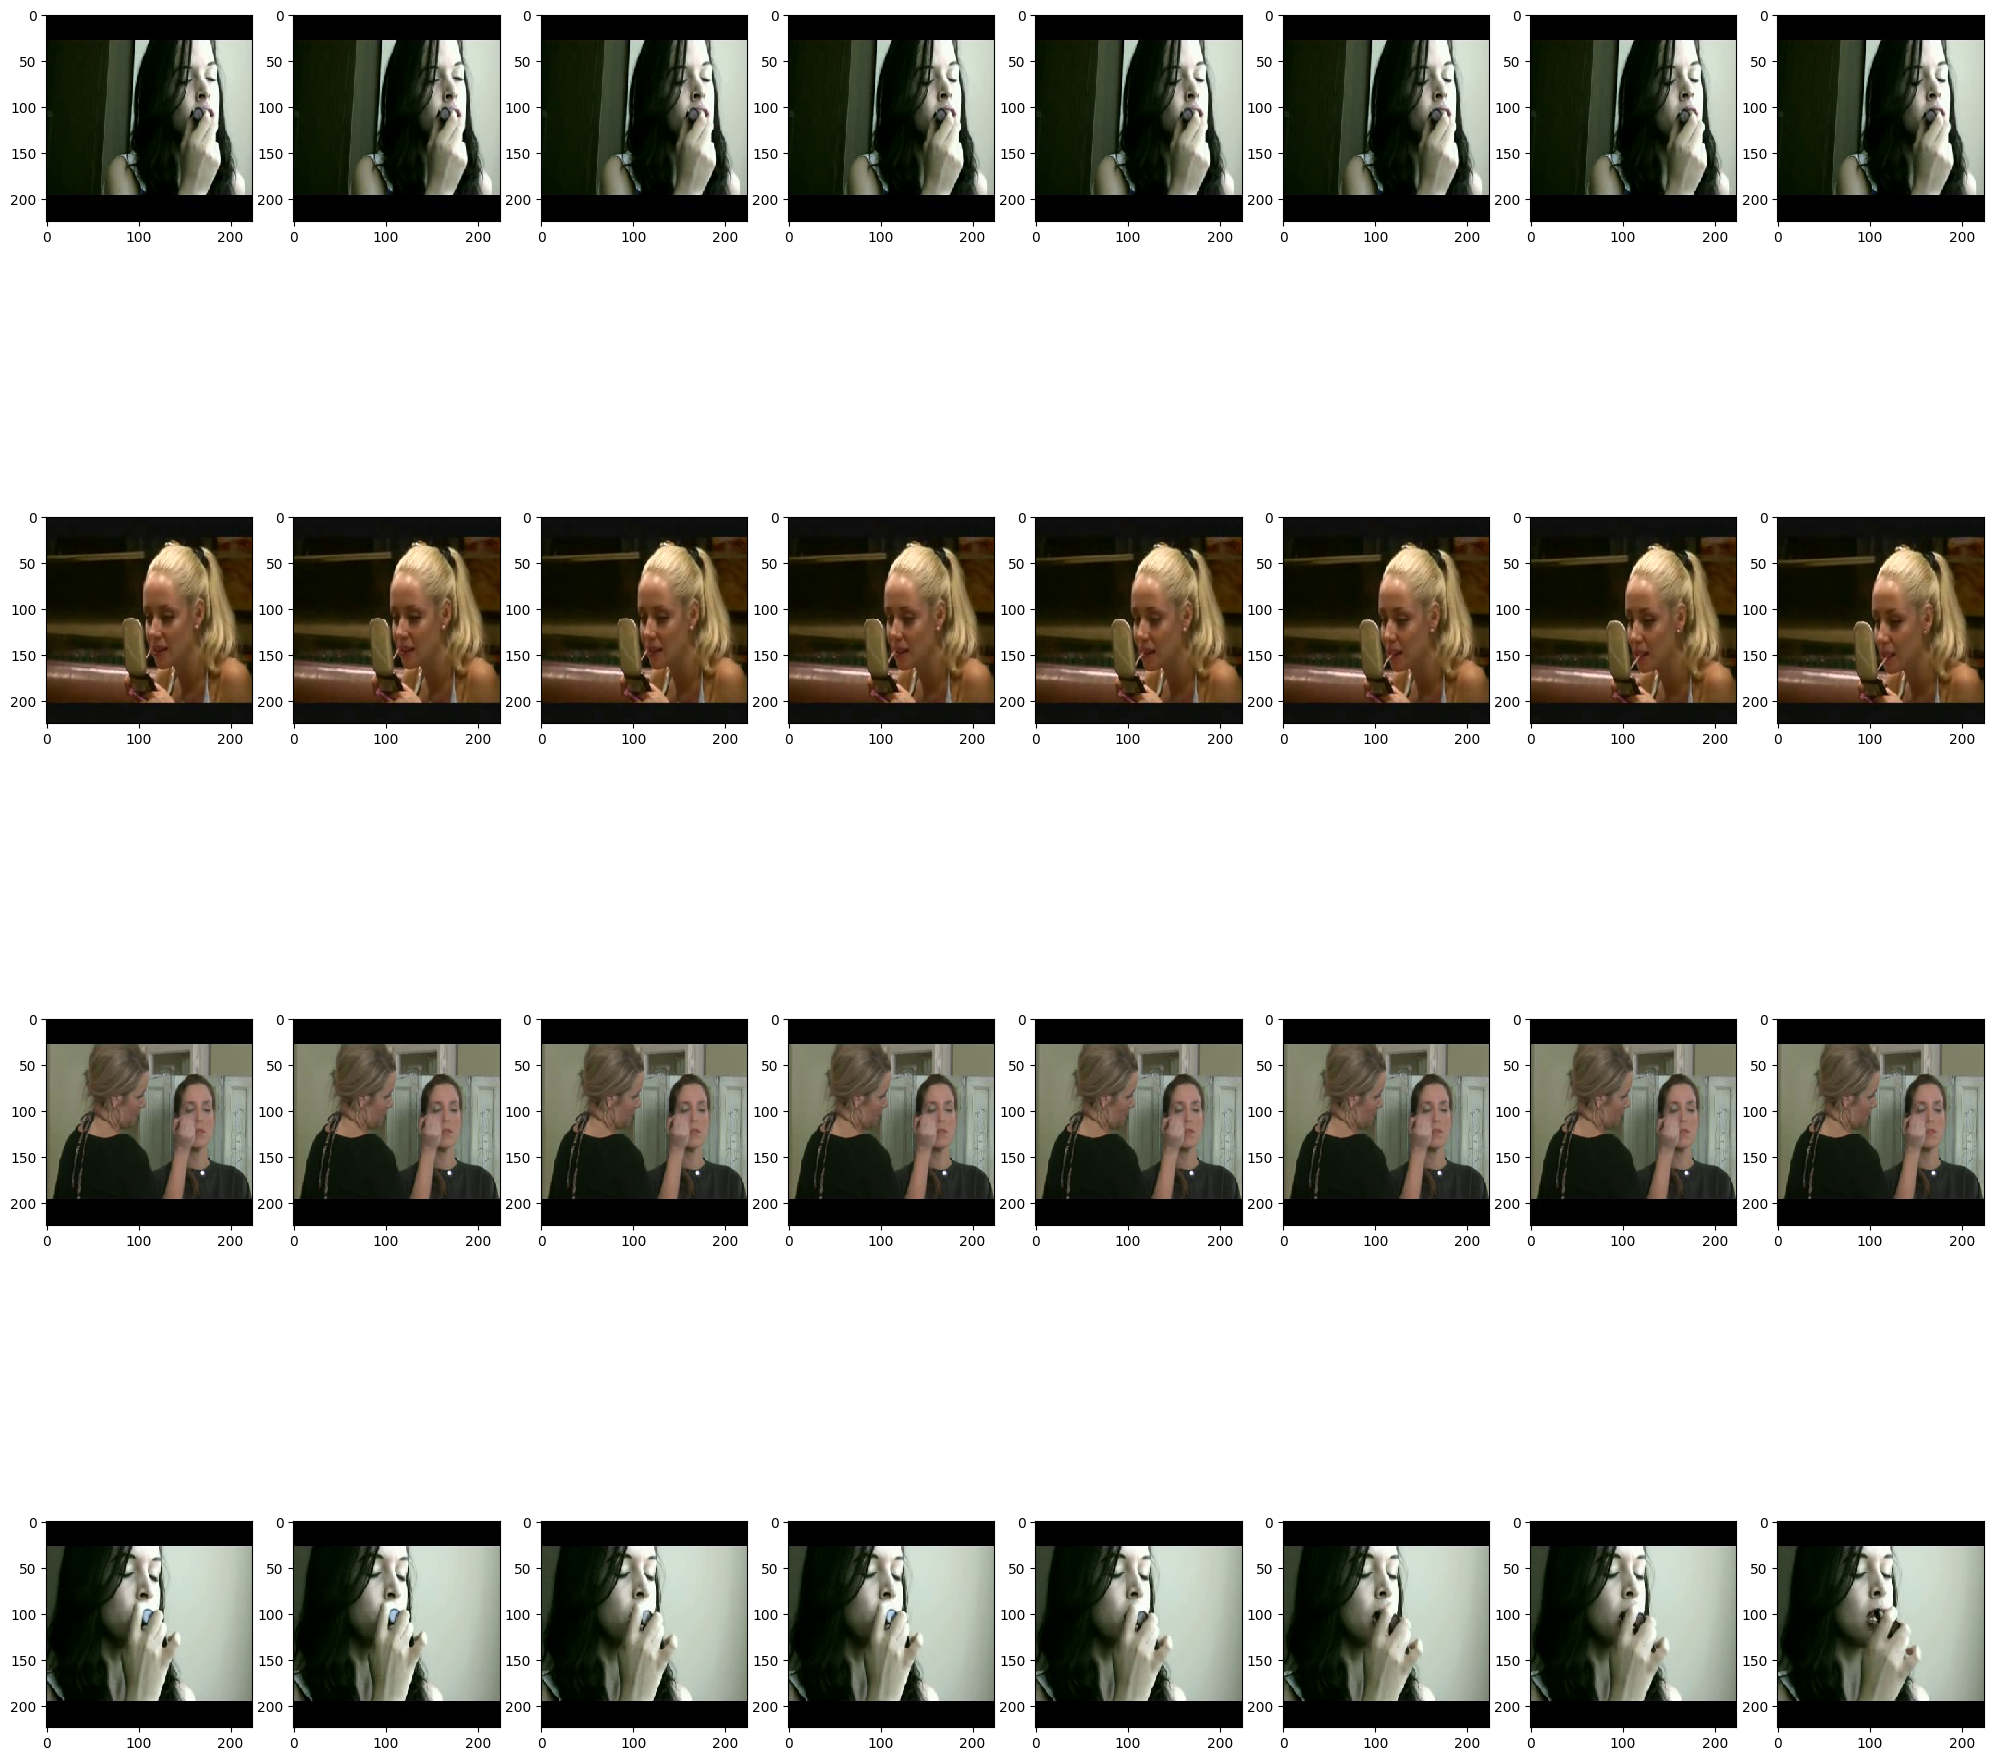

In [37]:
model.load_state_dict(torch.load('model.pt'))
model.eval()
for i, (train_input, train_target) in enumerate(train_loader):
    train_input_ = train_input.permute(0, 2, 3, 4, 1).numpy()
    train_target_ = train_target[:]
    train_target = train_target.cuda()
    train_input = train_input.cuda()
    output = model(train_input)
    val, index_ = torch.max(output, axis=1)

    if torch.sum(index_ == train_target.data).item() != 4:
        fig, (ax0, ax1, ax2, ax3) = plt.subplots(4, 8, figsize=(25, 25))
        ax1 = ax1.flatten()
        ax2 = ax2.flatten()
        ax3 = ax3.flatten()
        print("GT: ", classes[train_target[0]])
        print("Predicted: ", classes[index_[0]])
        for idx in np.arange(8):
            ax0[idx].imshow(np.squeeze(train_input_[0][idx]), interpolation='none')
        print("GT: ", classes[train_target[1]])
        print("Predicted: ", classes[index_[1]])
        for idx in np.arange(8):
            ax1[idx].imshow(np.squeeze(train_input_[1][idx]), interpolation='none')
        print("GT: ", classes[train_target[2]])
        print("Predicted: ", classes[index_[2]])
        for idx in np.arange(8):
            ax2[idx].imshow(np.squeeze(train_input_[2][idx]), interpolation='none')
        print("GT: ", classes[train_target[3]])
        print("Predicted: ", classes[index_[3]])
        for idx in np.arange(8):
            ax3[idx].imshow(np.squeeze(train_input_[3][idx]), interpolation='none')
        break